In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from keras.models import load_model
import keras as ks
from keras.preprocessing import image as kimage
import skimage.io as io
import random
import sys
import pickle as pkl
from imblearn.keras import BalancedBatchGenerator
from keras.utils import np_utils
lib_path = os.path.join(os.path.realpath(r"C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\DataAugmentationForObjectDetection-master"), "data_aug")
sys.path.append(lib_path)
from bbox_util import *
from data_aug import *
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model
from keras.layers import Concatenate,Input, Dense, Flatten, Reshape, MaxPooling2D, Conv2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, explained_variance_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
import skimage.measure
from scipy.spatial import distance
from collections import OrderedDict

### Load dati e modelli

In [2]:
def model_multi_task():
    visible = Input(shape=(40,40,3)) #(None,None,3)
    x1 = Conv2D(16, kernel_size=3, strides=1)(visible)
    x1 = LeakyReLU(alpha=0.1)(x1)
    x1 = BatchNormalization()(x1)
    x2 = Conv2D(32, kernel_size=3, strides=1)(x1)
    x2 = LeakyReLU(alpha=0.1)(x2)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x3 = Conv2D(32, kernel_size=3, strides=1)(x2)
    x3 = LeakyReLU(alpha=0.1)(x3)
    x3 = BatchNormalization()(x3)
    x4 = Conv2D(43, kernel_size=3, strides=1)(x3)
    x4 = LeakyReLU(alpha=0.1)(x4)
    x4 = BatchNormalization()(x4)
    x4 = MaxPooling2D(pool_size=(2, 2))(x4)
    x5 = Conv2D(43, kernel_size=1, strides=2)(x4)
    x5 = LeakyReLU(alpha=0.1)(x5)
    x5 = BatchNormalization()(x5)
    x_f = Flatten()(x5)
    x_1 = Dense(512, activation = 'relu')(x_f)
    x_1 = Dropout(0.5)(x_1)
    output1 = Dense(43, activation = 'softmax', name = 'classificazione') (x_1)
    x_2 = Dense(512, activation = 'relu')(x_f)
    x_2 = Dropout(0.5)(x_2)
    output2 = Dense(4, activation='linear', name = 'regressione')(x_2)
    model = Model(inputs=visible, outputs=[output1, output2])
    return model

In [ ]:
model_conv = load_model('models/modello_si_no.h5')
model_conv.load_weights('weights/pesi_si_no.hdf5')
model_multi_task = model_multi_task()
model_multi_task.load_weights('weights/classificazione_multiclasse.hdf5')

In [4]:
X_1 = np.load('array_da_importare/train_speriamo_bene_completo_X.npy')
y_1 = np.load('array_da_importare/train_speriamo_bene_completo_Y.npy')
X_train1, y_train1 = X_1, y_1
X_train1 = X_train1/255
df = pd.read_csv('final_segnali_stradali.csv', sep = ';')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
#X_test = X_test/255

### Risultati

In [5]:
from keras.applications import resnet
X_inference = resnet.preprocess_input(X_test)
y_inference = np_utils.to_categorical(y_test[:,0])

In [6]:
preds = model_conv.predict(X_inference)

In [7]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test[:,0], np.argmax(preds, axis = 1))

0.9997624703087886

# Funzioni utili

In [8]:
def resize_img(im):
    multipli40 = np.arange(start = 40, stop = max(im.shape) + 40, step = 40)
    index_x = np.argmin(np.absolute(multipli40-im.shape[1]))
    new_x = multipli40[index_x]
    index_y = np.argmin(np.absolute(multipli40-im.shape[0]))
    new_y = multipli40[index_y]
    resized = cv2.resize(im, (new_x, new_y), interpolation = cv2.INTER_AREA)
    return resized

# Creo sliding window

In [9]:
X_1 = np.load('array_da_importare/train_speriamo_bene_completo_X.npy')
y_1 = np.load('array_da_importare/train_speriamo_bene_completo_Y.npy')
X_train1, y_train1 = X_1, y_1
#X_train1 = X_train1/255
df = pd.read_csv('final_segnali_stradali.csv', sep = ';')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
#X_test = X_test/255

In [10]:
def create_d(app, x1, x2, y1, y2, x1_real, x2_real, y1_real, y2_real, prob, stride, im_shape, i, j):
    signal, bbox = model_multi_task.predict(app/255)
    signal = np.argmax(signal)
    d = {}
    d['imm'] = np.squeeze(app)
    d['real_coord'] = np.array([[x1_real, x2_real, y1_real, y2_real]])
    d['bbox'] = bbox
    d['signal'] = signal
    d['signal_name'] = df[df['target']==signal]['title']
    d['prob'] = prob
    d['coord_imm'] = np.array([[x1, x2, y1, y2]])
    d['stride'] = stride
    d['dim'] = im_shape
    return d

In [11]:
def generate_sizes(shape, iterations):
    first = False
    if shape[0]>shape[1]:
        first = True
    min_shape = min(shape)
    ratio = max(shape)/min(shape)
    difference_from_40 = min_shape - 40
    list_of_shapes = []
    for i in range(1, iterations + 1, 1):
        if first == True:
            list_of_shapes.append((int((min_shape-difference_from_40)*i*ratio), int((min_shape-difference_from_40)*i)))
        else:
            list_of_shapes.append((int((min_shape-difference_from_40)*i), int((min_shape-difference_from_40)*i*ratio)))
    return list_of_shapes

In [12]:
def sliding_window(im, diz, original_size, stride=4, max_euclid = 15):
    im_shape = im.shape
    im = np.expand_dims(im, axis = 0)
    r = 0
    c = 0
    Rx = im_shape[0]/original_size[0]
    Ry = im_shape[1]/original_size[1]
    for i in range(0, round((im.shape[1]-40)/stride+1)):
        for j in range(0, round((im.shape[2]-40)/stride+1)):
            app = np.expand_dims(im[0, r:r+40, c:c+40], axis = 0)
            p = resnet.preprocess_input(app)
            pred = model_conv.predict(p)
            if (np.argmax(pred) == 1): #SE VIENE INDIVIDUATO UN SEGNALE
                prob = pred[0][1] #prob con la quale viene individuato il segnale
                x1 = j*stride * Rx
                x2 = (j*stride + 40) * Rx
                y1 = i*stride * Ry
                y2 = (i*stride + 40) * Ry
                x1_real = j*stride / Rx
                x2_real = (j*stride + 40) / Rx
                y1_real = i*stride / Rx
                y2_real = (i*stride + 40) / Rx
                if len(diz)>0: #se il dizionario contiene almeno un elemento
                    min_dist = 1000000 #la distanza minima tra gli elementi del dizionario e le coordinate correnti x1,y1,x2,y2
                    #find = False #se ho trovato un immagine che ha distanza euclidea minore di quella più vicina
                    it = 'boh' #item nel dizionario
                    for item in diz:
                        dist = distance.euclidean(diz[item]['coord_imm'], np.array([[x1, x2, y1, y2]]))
                        if (dist<min_dist):
                            min_dist = dist
                            it = item
                    if(min_dist<max_euclid) & (prob > diz[it]['prob']):
                        diz[it] = create_d(app, x1, x2, y1, y2, x1_real, x2_real, y1_real, y2_real, prob, stride, im_shape, i, j)
                    if(min_dist>max_euclid):
                        diz['imm{}'.format(len(diz.keys()))] = create_d(app, x1, x2, y1, y2, x1_real, x2_real, y1_real, y2_real, prob, stride, im_shape, i, j)
                else:
                    d = create_d(app, x1, x2, y1, y2, x1_real, x2_real, y1_real, y2_real, prob, stride, im_shape, i, j)
                    diz['imm{}'.format(len(diz.keys()))] = d
            c = c + stride
        r = r + stride
        c = 0
    return diz

In [13]:
def clean_dict(diz, euclidean):
    new_d = diz.copy()
    for d in diz:
        coords = diz[d]['coord_imm']
        min_dist = 10000
        it = 'boh'
        pr = 0
        for d2 in diz:
            dist = distance.euclidean(diz[d2]['coord_imm'], coords)
            if (dist<min_dist)&(d2!=d):
                min_dist = dist
                it = d2
                pr = diz[d2]['prob']
        if (min_dist<euclidean) & (diz[d]['prob']<pr):
            del new_d[it]
    return new_d

In [14]:
def execution(img, iterations = 4, stride=4, max_euclid = 15, show = False):
    diz = {}
    img = resize_img(img)
    #print(img.shape)
    original_shape = img.shape
    #print(original_shape)
    list_of_shapes = generate_sizes(original_shape[0:2], iterations)
    for shape in list_of_shapes:
        #print(shape)
        im = cv2.resize(img, (shape[1], shape[0])) 
        #plt.imshow(im/255); plt.show;
        #print(resize_img(im).shape)
        diz = sliding_window(resize_img(im), diz, original_shape, stride, max_euclid)
    diz = clean_dict(diz, max_euclid)
    if show == True:
        img01 = img/255
        for d in diz:
            immagine = diz[d]['imm']/255
            porzione = draw_rect(immagine, np.concatenate([diz[d]['bbox'],np.zeros([1,1])], axis = 1))
            #plt.imshow(porzione); plt.show()
            x1 =  int(diz[d]['real_coord'][0][0])
            x2 = int(diz[d]['real_coord'][0][1])
            y2 = int(diz[d]['real_coord'][0][3])
            y1 = int(diz[d]['real_coord'][0][2])
            grandezzax = x2 - x1
            grandezzay = y2 - y1
            porzione = cv2.resize(porzione, (grandezzax, grandezzay))
            img01[y1:y2, x1:x2, :] = porzione
        plt.imshow(img01); plt.show()
    return diz

### Test su immagini varie

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


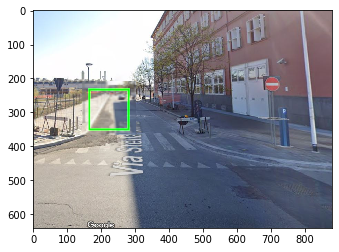

13    Dare precedenza
Name: title, dtype: object


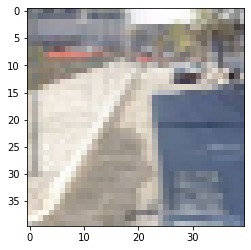

In [28]:
im = io.imread('Immagini_prova/bicocca3.jpg')
diz = execution(im, iterations = 4, stride=4, max_euclid = 100, show = True)
for d in diz:
    print(diz[d]['signal_name'])
    plt.imshow(diz[d]['imm']); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


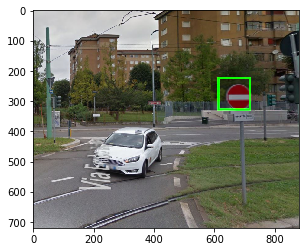

17    Senso vietato
Name: title, dtype: object


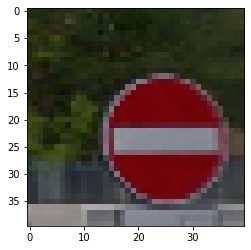

In [22]:
im = io.imread('Immagini_prova/bicocca2.jpg')
diz = execution(im, iterations = 5, stride=4, max_euclid = 70, show = True)
for d in diz:
    print(diz[d]['signal_name'])
    plt.imshow(diz[d]['imm']); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


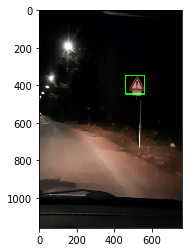

31    Animali selvatici vaganti
Name: title, dtype: object


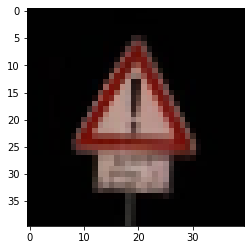

In [18]:
im = io.imread('Immagini_prova/roma.jpg')
diz = execution(im, iterations = 6, stride=4, max_euclid = 70, show = True)
for d in diz:
    print(diz[d]['signal_name'])
    plt.imshow(diz[d]['imm']); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


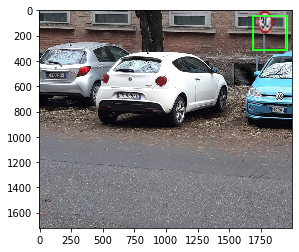

17    Senso vietato
Name: title, dtype: object


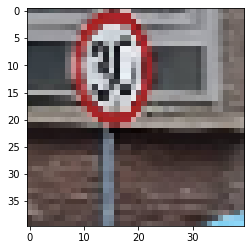

In [15]:
im = io.imread('Immagini_prova/bicocca.jpg')
diz = execution(im, iterations = 5, stride=4, max_euclid = 40, show = True)
for d in diz:
    print(diz[d]['signal_name'])
    plt.imshow(diz[d]['imm']); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


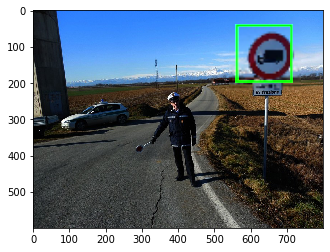

16    Divieto di transito agli autocarri che superan...
Name: title, dtype: object


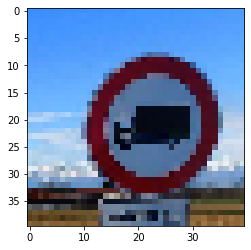

In [16]:
im = io.imread('Immagini_prova/segnali11.jpg')
diz = execution(im, iterations = 3, stride=4, max_euclid = 40, show = True)
for d in diz:
    print(diz[d]['signal_name'])
    plt.imshow(diz[d]['imm']); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


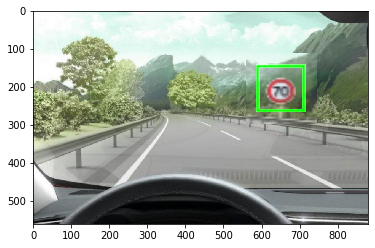

4    Limite massimo di velocità di 70 Km/h
Name: title, dtype: object


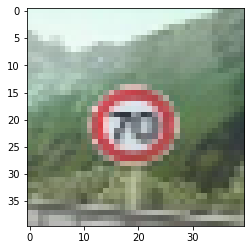

In [17]:
im = io.imread('Immagini_prova/cartoon.jpg')
diz = execution(im, iterations = 3, stride=4, max_euclid = 40, show = True)
for d in diz:
    print(diz[d]['signal_name'])
    plt.imshow(diz[d]['imm']); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


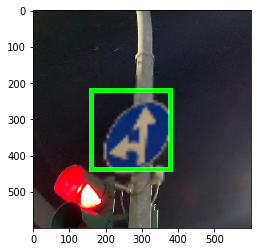

37    Direzioni consentite diritto e sinistra
Name: title, dtype: object


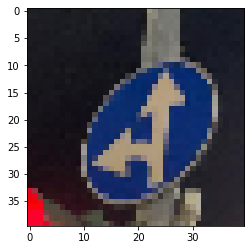

In [18]:
im = io.imread('Immagini_prova/segnali3.jpg')
diz = execution(im, iterations = 3, stride=4, max_euclid = 40, show = True)
for d in diz:
    print(diz[d]['signal_name'])
    plt.imshow(diz[d]['imm']); plt.show()